In [20]:
import numpy as np
import matplotlib.pyplot as plt
from data_load import load_data, pmumu, nll, lam_i, parabolic, nll_dm2, nll_theta, deltaNLL, curv_method

data, flux = load_data()

# Brute Force Grid Search

This method is computationally taxing but robust - scan both values and evaluate NLL on a $N_{\theta}$ x $N_{\Delta m^2}$ grid and select point with lowest NLL as the best fit.

This function is pretty low dimensional and smooth near the minimum (very similar values from using curvature apporximation and a full grid scan), so this method is the simplest to globally search for the minimum.

In [21]:
def minimise_2d(nll, theta_range_min, theta_range_max, dm2_range_min, dm2_range_max, n_theta = 200, n_dm2= 200):
    """
   2D minimiser for nll with no fixed values

    nll  = function of (theta, dm2)
    theta_min/max = range for theta
    dm2_min/max =  range for dm2
    n_theta = no. of points in theta
    n_dm2   = no. of points in dm2

    Returns tminimum values of theta, dm2 and the function
    """

    thetas = np.linspace(theta_range_min, theta_range_max, n_theta)
    dm2s   = np.linspace(dm2_range_min,   dm2_range_max,   n_dm2)
    grid = np.zeros((n_dm2, n_theta))
    best_val, theta_best, dm2_best = None, None, None

    for i, t in enumerate(thetas):
        for j, d in enumerate(dm2s):
            val = nll(t, d)
            grid[j, i] = val
            if (best_val is None) or (val < best_val) :
                best_val   = val
                theta_best = t
                dm2_best   = d

    return theta_best, dm2_best, best_val, thetas, dm2s, grid

In [22]:
def test(x, y):
    return (x + 1.0)**2 + (y + 1.0)**2

x_test, y_test, f0_test, xs, ys, grid = minimise_2d(test, -2, 2, -3, 3)
print(x_test, y_test, f0_test)# xs, ys, grid) 

-0.9949748743718594 -1.0100502512562815 0.0001262594378929825


In [23]:
theta_best, dm2_best, nll_best, thetas, dm2s, nll_grid = minimise_2d(nll, theta_range_min = 0.0, theta_range_max = 0.5*np.pi, dm2_range_min = 1.0e-3, dm2_range_max = 4.0e-3, n_theta = 200,n_dm2 = 200)

print('2D best fit:')
print(f'theta_23 = {theta_best:.3f}')
print(f'dm2_23   = {dm2_best:.4f}')
print(f'nll_min  = {nll_best:.3f}')

2D best fit:
theta_23 = 0.679
dm2_23   = 0.0025
nll_min  = -84.740


In [24]:
print(f'theta_23 = {theta_best:.3f}')
print(f'dm2_23   = {dm2_best:.5f}')
print(f'nll_min  = {nll_best:.1f}')

theta_23 = 0.679
dm2_23   = 0.00249
nll_min  = -84.7


# Newton Method and Hessian

Near the minimum the NLL behaves like a quadratic (as mentioned before numerous times), but it can be approximated as:

$$
NLL \approx NLL_{min} + \frac{1}{2}(\underline{x}-\underline{x_0})^T \underline{\underline{H}}(\underline{x}-\underline{x_0})
$$

Where H = Hessian matrix

We can thereby use the Newton Method (which uses $\nabla NLL$ and the Hessian matrix of 2nd Derivs) at ($\theta, \Delta m^2$) to update:

$$
\underline{x_{1}} = \underline{x_0} - \underline{\underline{H}}^{-1}\nabla NLL(\underline{x_0})
$$

We approximate the gradient using central difference scheme:

$$
\frac{\partial NLL}{\partial \theta} \approx \frac{NLL(\theta + h, \Delta m^2) -NLL(\theta - h, \Delta m^2)}{2h}
$$
And similary for $\Delta m^2$ and then fill the Hessian using mixed derivatives with multiple iterations being used to test multiple possible values from the 'right' area

In [25]:
def grad_hess_2d(f, theta, dm2, h_th=1e-3, h_dm2=1e-5):
    """
    Finite-difference gradient and Hessian of f(theta, dm2) at (theta, dm2).

    Returns grad = np.array([df/dtheta, df/ddm2]) and Hessian (H) = 2x2 Hessian matrix
    """

    f0   = f(theta, dm2)

    # compute first derivs via central difference
    deriv1_th_plus  = f(theta + h_th, dm2)
    deriv1_th_minus = f(theta - h_th, dm2)
    deriv1_dm_plus  = f(theta, dm2 + h_dm2)
    deriv1_dm_minus = f(theta, dm2 - h_dm2)

    dfdtheta = (deriv1_th_plus - deriv1_th_minus) / (2.0*h_th)
    dfddm2   = (deriv1_dm_plus - deriv1_dm_minus) / (2.0*h_dm2)

    # second derivs
    deriv2_theta = (deriv1_th_plus - 2.0*f0 + deriv1_th_minus) / (h_th**2)
    deriv2_dm2   = (deriv1_dm_plus - 2.0*f0 + deriv1_dm_minus) / (h_dm2**2)

    # mixed derivativs d2f/dtheta ddm2 to store in Hessian
    f_pp = f(theta + h_th, dm2 + h_dm2)
    f_pm = f(theta + h_th, dm2 - h_dm2)
    f_mp = f(theta - h_th, dm2 + h_dm2)
    f_mm = f(theta - h_th, dm2 - h_dm2)

    mixed_deriv = (f_pp - f_pm - f_mp + f_mm) / (4.0*h_th*h_dm2)

    grad = np.array([dfdtheta, dfddm2])
    H    = np.array([[deriv2_theta,   mixed_deriv],
                     [mixed_deriv, deriv2_dm2]])

    return grad, H



In [26]:
def newton_2d(f, theta_min, dm2_min, n_iter=5, h_th=1e-3, h_dm2=1e-5):
    """
    Newton method for NLL(theta, dm2) starting from (theta0, dm20) for further refinement

    Returns theta, dm2, NLL(theta, dm2)
    """

    for k in range(n_iter):
        grad, H = grad_hess_2d(f, theta_min, dm2_min, h_th=h_th, h_dm2=h_dm2)

        try:
            step = np.linalg.solve(H, grad)
        except np.linalg.LinAlgError:
            break

        # x_new = x_old - H^{-1} grad
        theta_1 = theta_min - step[0]
        dm2_1   = dm2_min  - step[1]

        # extra damped!
        theta_1 = theta_min - 0.5*step[0]
        dm2_1   = dm2_min  - 0.5*step[1]

        theta_min, dm2_min = theta_1, dm2_1

    return theta_min, dm2_min, f(theta_min, dm2_min)

theta_newton, dm2_newton, nll_newton = newton_2d(nll, theta_best, dm2_best)

In [27]:
x_newton, y_newton, f_newton = newton_2d(test, x_test, y_test)

print(x_newton, y_newton, f_newton )

-0.9998429648241206 -1.0003140703517426 1.2330023230717964e-07


In [28]:
print(f'Newton Method Theta: {theta_newton}, NM dm2: {dm2_newton:}, NM NLL: {nll_newton:.3f}')

Newton Method Theta: 0.6769516214833124, NM dm2: 0.002494993908089019, NM NLL: -84.786


In [29]:
print(f'Overall Change Theta: {theta_best - theta_newton:.4f}, Overall Change dm2: {abs(dm2_best - dm2_newton):.6f}, Overall Change NLL: {nll_best - nll_newton:.2f}')

Overall Change Theta: 0.0019, Overall Change dm2: 0.000003, Overall Change NLL: 0.05


In [30]:
dm2_deltaNLL, dm2_minus, dm2_plus, ddm2_minus, ddm2_plus = deltaNLL(nll_dm2, range_min = 2.0e-3,range_max = 3.0e-3)
theta_deltaNLL, theta_minus, theta_plus, dtheta_minus, dtheta_plus = deltaNLL(nll_theta, range_min = 0.0,range_max = 0.5*np.pi)


sigma_theta = curv_method(nll_theta, theta_newton)
sigma_dm2 = curv_method(nll_dm2, dm2_newton, step_size = 1e-5)



NLL upwards scan value:-83.71113911658372
NLL downwards scan value:-83.7388608333043
NLL upwards scan value:-72.39395345077713
NLL downwards scan value:-72.30318526922338


In [31]:
print(f'base NLL min val {nll_newton:.3f}')

base NLL min val -84.786


In [32]:
print(f'Error Width theta: {(dtheta_minus + dtheta_plus):.4f}')
print(f'Error Width dm2: {(ddm2_minus +ddm2_plus):.7f}')

print(f'Average Error theta: {(dtheta_minus - dtheta_plus)/2:.5f}')
print(f'Average Error dm2: {(abs(ddm2_minus - ddm2_plus))/2:.9f}')

print(f'Relative Error Theta Minus: {dtheta_minus/theta_deltaNLL * 100:.3f}%')
print(f'Relative Error Dm2 Minus: {ddm2_minus/dm2_deltaNLL * 100:.3f}%')

print(f'Relative Error Theta Plus: {dtheta_plus/theta_deltaNLL * 100:.3f}%')
print(f'Relative Error Dm2 Plus: {ddm2_plus/dm2_deltaNLL * 100:.3f}%')

Error Width theta: 0.0256
Error Width dm2: 0.0000314
Average Error theta: 0.00050
Average Error dm2: 0.000000120
Relative Error Theta Minus: 1.966%
Relative Error Dm2 Minus: 0.633%
Relative Error Theta Plus: 1.817%
Relative Error Dm2 Plus: 0.624%


In [33]:
print(f'sigma theta: {sigma_theta:.3f}, sigma dm2: {sigma_dm2:.6f}')

print(f'Relative Error Theta: {sigma_theta/theta_newton * 100:.3f}%')
print(f'Relative Error Dm2: {sigma_dm2/dm2_newton * 100:.3f}%')

sigma theta: 0.013, sigma dm2: 0.000016
Relative Error Theta: 1.890%
Relative Error Dm2: 0.629%


In [34]:
print(f'{ddm2_minus:.7f}, {ddm2_plus:.7f}')
print(f'{dtheta_minus:.3f}, {dtheta_plus:.3f}')

0.0000158, 0.0000156
0.013, 0.012


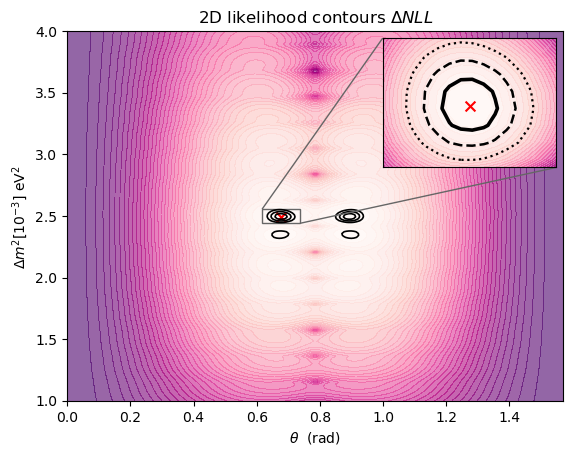

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


Theta, Dm2 = np.meshgrid(thetas, dm2s)
dnll = nll_grid - np.min(nll_grid)

fig, norm  = plt.subplots()

cf = norm.contourf(Theta, Dm2*1e3, dnll, levels = 50, cmap = 'RdPu', alpha = 0.6)

norm.contour(Theta, Dm2*1e3, dnll, levels = [2.30, 6.18, 11.83], colors = 'Black', linewidths = 1.2)

norm.scatter(theta_newton, dm2_newton*1e3, marker = 'x', s = 50, color = 'red')
norm.set_xlabel('$\\theta$  (rad)')
norm.set_ylabel('$\Delta m^2 [10^{-3}]$ eV$^2$ ')
norm.set_title('2D likelihood contours $\Delta NLL$')
#norm.set_xlim(0.4, 1.2)
#norm.set_ylim(1.5, 3)


zoom = inset_axes(norm, width = '35%', height = '35%', loc = 'upper right')

zoom.contourf(Theta, Dm2*1e3, dnll, levels = np.linspace(0,50, 30), cmap = 'RdPu', alpha = 0.6)
zoom.contour(Theta, Dm2*1e3, dnll, levels = [2.30], linewidths = 2.6, colors = 'black')
zoom.contour(Theta, Dm2*1e3, dnll, levels = [6.18], linewidths = 1.8, colors = 'black', linestyles = '--')
zoom.contour(Theta, Dm2*1e3, dnll, levels = [11.83], linewidths = 1.6, colors = 'black', linestyles = ':')


zoom.scatter(theta_newton, dm2_newton*1e3, marker = 'x', s = 50, color = 'red')
zoom.set_xlim(theta_newton - 0.06, theta_newton + 0.06)
zoom.set_ylim((dm2_newton - 5.5e-5)*1e3, (dm2_newton + 6e-5)*1e3)

zoom.set_xticks([])
zoom.set_yticks([])

mark_inset(norm, zoom, loc1=2, loc2=4, fc='none', ec='0.4')

plt.show()
plt.close()

For a 2D NLL instead of $\Delta \text{NLL} = 1\sigma = 1 $ corresponding to 1, it instead corresponds to $\approx 2.30$ and then for $\Delta NLL = 2\sigma \approx 6.18$ and $ 3\sigma \approx 11.83$. These have been used to plot the confidence contours of where the minimum is located.

As we can see there are two islands that could correspond to the minimum but only one has been chosen to correspond to the true minimum. This reflects the shape we saw of the $\theta$ NLL